# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** LightGBM + nice post-processing

</font>
</div>

# Import modules
<hr style="border:2px solid black"> </hr>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20
np.random.seed(1)

# Create dataset

In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)


#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

X.shape, y.shape, xx.shape

((100, 1), (100,), (1000, 1))

# General data

In [3]:
# model parameters
LEARNING_RATE = 0.1
N_ESTIMATORS = 500
MAX_DEPTH = 6
NUM_LEAVES = 128  # lgbm only
OBJECTIVE = 'quantile'  # lgbm only, 'quantile' or 'quantile_l2'
REG_SQRT = True  # lgbm only

ALPHA = 0.95

# Helper function

In [20]:
def plot(y_pred, y_upper, y_lower, frac_above_upper, frac_below_lower):
    plt.figure(dpi=100)
    plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
    plt.plot(X, y, 'b.', markersize=5, label=u'Observations')
    plt.plot(xx, y_pred, 'r-', label=u'Mean Prediction')
    plt.plot(xx, y_upper, 'k-')
    plt.plot(xx, y_lower, 'k-')
    plt.fill(np.concatenate([xx, xx[::-1]]),
             np.concatenate([y_upper, y_lower[::-1]]),
             alpha=0.5, fc='b', ec='None', label=(str(round(100*(ALPHA-0.5)*2))+'% prediction interval'))
    plt.scatter(x=X[y_autohigh < y], y=y[y_autohigh < y], s=50, marker='x', c='red',
                label=str(round(100*frac_above_upper, 1))+'% of training data above upper (expect '+str(round(100*(1-ALPHA), 1))+'%)')
    plt.scatter(x=X[y_autolow > y], y=y[y_autolow > y], s=50, marker='x', c='orange',
                label=str(round(100*frac_below_lower, 1)) + '% of training data below lower (expect '+str(round(100*(1-ALPHA), 1))+'%)')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(-10, 20)
    plt.legend(loc='upper left', ncol=2)
    plt.title('  Alpha: '+str(ALPHA) +
              '  N_est: '+str(N_ESTIMATORS) +
              '  L_rate: '+str(LEARNING_RATE) +
              '  N_Leaf: '+str(NUM_LEAVES) +
              '  Obj: '+str(OBJECTIVE) +
              '  R_sqrt: '+str(int(REG_SQRT))
              )
    plt.show()

# Upper quantile

In [5]:
clfh = lgb.LGBMRegressor(objective=OBJECTIVE,
                         alpha=ALPHA,
                         num_leaves=NUM_LEAVES,
                         learning_rate=LEARNING_RATE,
                         n_estimators=N_ESTIMATORS,
                         min_data_in_leaf=5,
                         reg_sqrt=REG_SQRT,
                         max_depth=MAX_DEPTH)
clfh.fit(X, y)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


LGBMRegressor(alpha=0.95, max_depth=6, min_data_in_leaf=5, n_estimators=500,
              num_leaves=128, objective='quantile', reg_sqrt=True)

# Lower quantile

In [6]:
clfl = lgb.LGBMRegressor(objective=OBJECTIVE,
                         alpha=1 - ALPHA,
                         num_leaves=NUM_LEAVES,
                         learning_rate=LEARNING_RATE,
                         n_estimators=N_ESTIMATORS,
                         min_data_in_leaf=5,
                         reg_sqrt=REG_SQRT,
                         max_depth=MAX_DEPTH)
clfl.fit(X, y)

LGBMRegressor(alpha=0.050000000000000044, max_depth=6, min_data_in_leaf=5,
              n_estimators=500, num_leaves=128, objective='quantile',
              reg_sqrt=True)

# Median quantile

In [8]:
clf = lgb.LGBMRegressor(objective="regression_l1",
                        num_leaves=NUM_LEAVES,
                        learning_rate=LEARNING_RATE,
                        n_estimators=N_ESTIMATORS,
                        min_data_in_leaf=5,
                        reg_sqrt=REG_SQRT,
                        max_depth=MAX_DEPTH)
clf.fit(X, y)

LGBMRegressor(max_depth=6, min_data_in_leaf=5, n_estimators=500, num_leaves=128,
              objective='regression_l1', reg_sqrt=True)

# Prediction

In [9]:
# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)
y_lower = clfl.predict(xx)
y_upper = clfh.predict(xx)

# Check calibration by predicting the training data.
y_autopred = clf.predict(X)
y_autolow = clfl.predict(X)
y_autohigh = clfh.predict(X)
frac_below_upper = round(np.count_nonzero(y_autohigh > y) / len(y), 3)
frac_above_upper = round(np.count_nonzero(y_autohigh < y) / len(y), 3)
frac_above_lower = round(np.count_nonzero(y_autolow < y) / len(y), 3)
frac_below_lower = round(np.count_nonzero(y_autolow > y) / len(y), 3)

# Post-processing

<div class="alert alert-block alert-info">
<font color=black><br>

-  What I **like** of this pros-processing is how the point were highlighted.

<br></font>
</div>

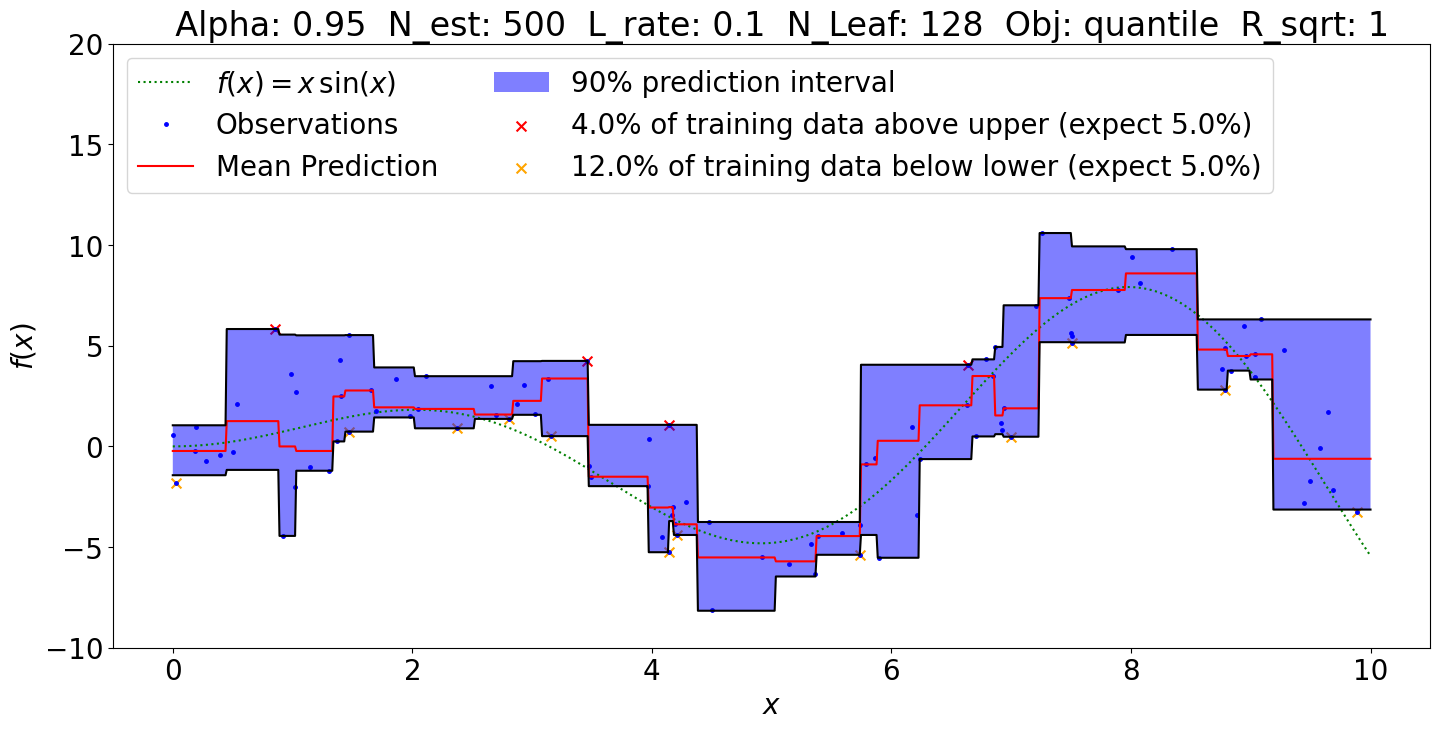

In [21]:
plot(y_pred, y_upper, y_lower, frac_above_upper, frac_below_lower)

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://github.com/ceshine/quantile-regression-tensorflow/blob/master/notebooks/02-sklearn-example-lightgbm.ipynb<br>

</font>
</div>

# Conclusions
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-danger">
<font color=black><br>

-

<br></font>
</div>